In [75]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import numpy as np

In [18]:
nqubits = 2

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
qc_p.rz(2*gamma,0)
qc_p.rzz(2*gamma,0,1)
    
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

global phase: -1.0*$\gamma$
     ┌─────────┐┌────────────────┐┌────────────────┐                       »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(2*$\gamma$) ├──■────────────────────»
     ├─────────┤├────────────────┤└────────────────┘┌─┴─┐┌────────────────┐»
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├──────────────────┤ X ├┤ Rz(2*$\gamma$) ├»
     └─────────┘└────────────────┘                  └───┘└────────────────┘»
«          
«q_0: ──■──
«     ┌─┴─┐
«q_1: ┤ X ├
«     └───┘

In [105]:
a=1000
b=300
def obj_func(x):
    
    if x=='00':
        return a+b
    if x=='01':
        return a-b
    if x=='10':
        return -b-a
    else:
        return b-a


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = -obj_func(bitstring[::-1])
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta):

    nqubits = 2
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        qc.rz(2*gamma[irep]*a,0)
        qc.rzz(2*gamma[irep]*b,0,1) 
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [108]:
from scipy.optimize import minimize


expectation = get_expectation()

res = minimize(expectation, 
                      np.ones(20), 
                      method='COBYLA')
res

     fun: -1261.328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 179
  status: 1
 success: True
       x: array([1.00016257, 2.15296059, 0.92342525, 2.26140007, 0.39332049,
       0.84302541, 0.58075213, 0.78428214, 0.87692128, 0.58173068,
       0.89005991, 0.86459306, 0.87077202, 0.95717561, 0.79815393,
       0.85341376, 0.99026113, 0.79534905, 0.8377773 , 0.99447646])

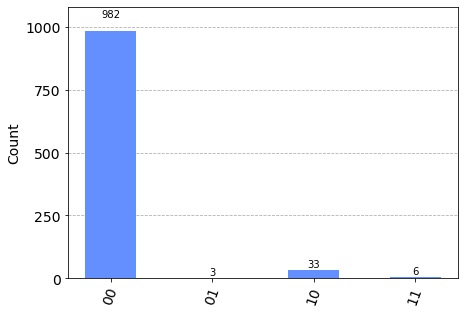

In [109]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)